## Análisis Diagnóstico: Componentes Principales en las ventas

El análisis de componentes principales (**ACP**), también conocido como principal component analysis (**PCA**) en inglés, es una técnica estadística utilizada para identificar patrones y relaciones en un conjunto de datos multivariados.

En términos simples, el **PCA** busca reducir la complejidad de los datos identificando las variables que más contribuyen a la variabilidad en los datos y combinándolas en nuevas variables llamadas componentes principales. Estos componentes se ordenan de mayor a menor importancia, por lo que los primeros componentes principales capturan la mayor parte de la variabilidad en los datos.

El objetivo principal del **PCA** es reducir la dimensión de los datos, es decir, representar los datos en un espacio de menor dimensión que el espacio original, sin perder información importante. Esto se logra al proyectar los datos en el espacio definido por los primeros componentes principales.

### Carga de las liberías de Python necesarias

Se importan las bibliotecas necesarias como pyodbc para conectarse a la base de datos, pandas para leer los datos, numpy para realizar cálculos numéricos, matplotlib y seaborn para la visualización de datos, y scipy para realizar pruebas formales.

In [13]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.options.display.float_format = '{:.2f}'.format

### Conexión a SQL Server para la extracción de los datos

In [14]:
conn_str = pyodbc.connect('Driver={SQL Server};' 'Server=LENOVO\SQLEXPRESS;''Database=AdventureWorks2019;''Trusted_Connection=yes;')
input_query = '''select
	 --CONCAT_WS('-',YEAR(t1.OrderDate), MONTH(t1.OrderDate)) as 'fecha',
	 sum(t1.TotalDue) as 'ventas',
	 sum(t2.OrderQty) as 'cantidad',
	 count(distinct t1.SalesOrderID) as 'transacciones',
	 sum(t1.TotalDue)/count(distinct t1.SalesOrderID) as 'monto_promedio',
	 sum(t2.OrderQty)/count(distinct t1.SalesOrderID) as 'cantidad_promedio',
	 count(distinct t2.ProductID) as 'variedad',
	 count(distinct t1.CustomerID) as 'clientes',
	 CASE 
		WHEN count(distinct t1.SalesPersonID)<1 THEN 1 ELSE count(distinct t1.SalesPersonID)
		end as 'vendedores'
from Sales.SalesOrderHeader as t1
	Inner join Sales.SalesOrderDetail as t2 on t1.SalesOrderID = t2.SalesOrderID
	group by YEAR(t1.OrderDate), MONTH(t1.OrderDate) 
	order by YEAR(t1.OrderDate), MONTH(t1.OrderDate)'''

sales_data = pd.read_sql(input_query, conn_str)

### Exploración del dataset extraído

Se observan las dimensiones y las variables que contiene el dataset extraído, correoborando que son variables relacionadas con las transacciones de ventas del negocio:

In [15]:
sales_data.shape

(38, 8)

In [16]:
sales_data.columns

Index(['ventas', 'cantidad', 'transacciones', 'monto_promedio',
       'cantidad_promedio', 'variedad', 'clientes', 'vendedores'],
      dtype='object')

In [17]:
sales_data.head(10)

,ventas,cantidad,transacciones,monto_promedio,cantidad_promedio,variedad,clientes,vendedores
0,8094970.21,825,43,188255.12,19,47,43,9
1,507096.47,141,141,3596.43,1,21,141,1
2,26081421.01,2209,231,112906.58,9,51,231,10
3,38009959.61,2904,250,152039.84,11,59,250,10
4,554791.61,157,157,3533.70,1,22,157,1
5,85739874.81,5382,327,262201.45,16,60,327,10
6,815313.02,230,230,3544.84,1,23,230,1
7,10980308.22,1040,228,48159.25,4,51,228,9
8,57438324.93,3967,336,170947.40,11,51,336,10
9,17925512.94,1442,219,81851.66,6,58,219,10


## Procesamiento de los datos

#### Cálculo de la correlación entre las variables

In [18]:
correlation = sales_data.corr()

#### Selección de las variables más correlacionadas con las ventas

In [19]:
correlation = correlation["ventas"].sort_values(ascending=False)

#### Visualización gráfica de las variables más correlacionadas

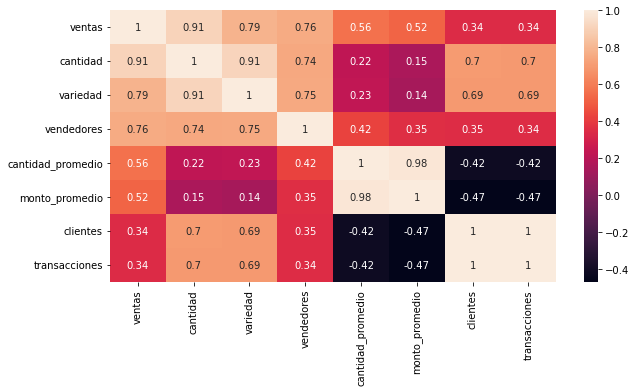

In [20]:
plt.figure(figsize=(10,5))
sns.heatmap(sales_data[correlation.index].corr(), annot=True)
plt.show()

### Pruebas formales para determinar la influencia de cada variable en las ventas

In [21]:
influencers = []
for variable in correlation.index:
    p_value = stats.pearsonr(sales_data["ventas"], sales_data[variable])[1]
    if p_value <= 0.05:
        influencers.append(variable)

#### Impresión de los resultados de las pruebas formales

Se imprimen los resultados de las variables influyentes en las ventas y se realizan pruebas de correlación para cada variable en la base de datos.

In [22]:
print("Variables influyentes en las ventas:")
for variable in influencers:
    print(variable)

Variables influyentes en las ventas:
ventas
cantidad
variedad
vendedores
cantidad_promedio
monto_promedio
clientes
transacciones


#### Pruebas de correlación para cada variable

In [23]:
for column in sales_data.columns:
    if column != "ventas":
        pearson_coef, p_value = stats.pearsonr(sales_data["ventas"], sales_data[column])
        if p_value < 0.05:
            print("La correlación entre ventas y {} es {} con un valor de p de {} (p < 0.05)".format(column, pearson_coef, p_value))
        else:
            print("La correlación entre ventas y {} es {} con un valor de p de {} (p >= 0.05)".format(column, pearson_coef, p_value))

La correlación entre ventas y cantidad es 0.9057703752057357 con un valor de p de 5.469292617035585e-15 (p < 0.05)
La correlación entre ventas y transacciones es 0.34057813715180396 con un valor de p de 0.03640801510769165 (p < 0.05)
La correlación entre ventas y monto_promedio es 0.5180397124548488 con un valor de p de 0.0008642187765879425 (p < 0.05)
La correlación entre ventas y cantidad_promedio es 0.5604428231026 con un valor de p de 0.00025278469521418926 (p < 0.05)
La correlación entre ventas y variedad es 0.7860849989924601 con un valor de p de 4.978176769572238e-09 (p < 0.05)
La correlación entre ventas y clientes es 0.34314319180156816 con un valor de p de 0.03493361004692532 (p < 0.05)
La correlación entre ventas y vendedores es 0.7561545193298099 con un valor de p de 4.0194117050500035e-08 (p < 0.05)


## Conclusiones

A partir de los resultados de las correlaciones entre ventas y las distintas variables, se puede concluir que todas las variables tienen una correlación positiva significativa con las ventas, ya que todos los valores de **p** son menores a **0.05**. Sin embargo, la variable que presenta la correlación más alta con las ventas es la *cantidad*, seguida de *variedad* y *la cantidad de vendedores*. 

Por lo tanto, se puede decir que estas variables tienen una mayor influencia en las ventas de la empresa. Además, la *transacciones* y la cantidad de los *clientes* también tienen una correlación significativa con las ventas, aunque en menor medida. En cuanto al *monto_promedio*, también presenta una correlación positiva con las ventas, pero en menor medida que las variables mencionadas anteriormente.

## Recomendaciones

Basándonos en las conclusiones obtenidas a partir de las correlaciones entre ventas y las distintas variables, se pueden sugerir algunas recomendaciones a la empresa para mejorar su desempeño en términos de ventas:

* *Incrementar la cantidad promedio por transacción*: Esta variable presenta la correlación más alta con las ventas, por lo que la empresa puede enfocarse en incentivar a los clientes a adquirir más productos en cada compra.

* *Ampliar la variedad de productos ofrecidos*: La correlación entre ventas y variedad también es alta, lo que indica que los clientes valoran tener una amplia selección de productos disponibles para comprar. Por lo tanto, la empresa podría considerar ampliar su oferta de productos para atraer a más clientes.

* *Aumentar el número de vendedores*: La correlación entre ventas y vendedores es significativa, lo que sugiere que tener más vendedores podría contribuir a aumentar las ventas. La empresa podría considerar contratar más personal de ventas o explorar otras estrategias de ventas para ampliar su equipo.

* *Mejorar la experiencia de compra en línea*: Dado que la cantidad de transacciones también tiene una correlación significativa con las ventas, la empresa podría considerar invertir en la mejora de su plataforma de ventas en línea para facilitar la experiencia de compra para los clientes.

* *Fidelizar a los clientes actuales*: La correlación entre ventas y clientes sugiere que mantener una base sólida de clientes fieles puede ser beneficioso para las ventas de la empresa. Por lo tanto, la empresa podría considerar implementar programas de fidelización o recompensas para mantener a sus clientes actuales satisfechos y motivarlos a seguir comprando en la empresa.